**Capone Aldo**

**Matricola 0001034517**

**Product Recognition on Store Shelves**

Object detection techniques based on computer vision can be deployed in super market scenarios for the
creation of a system capable of recognizing products on store shelves.
Given the image of a store shelf, such a system should be able identify the different products present
therein and may be deployed, e.g. to help visually impaired costumers or to automate some common store
management tasks (e.g. detect low in stock or misplaced products).

**Overall Task:**

Develop a computer vision system that, given a reference image for each product, is able to identify boxes
of cereals of different brands from one picture of a store shelf. For each type of product displayed in the
shelf the system should report:
1. Number of instances.
2. Dimension of each instance (width and height of the bounding box that enclose them in pixel).
3. Position in the image reference system of each instance (center of the bounding box that enclose
them in pixel).


**Step A** *- Multiple Product Detection*:

Test on scene image: {e1.png, e2.png, e3.png, e4.png, e5.png}

Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}

Develop an object detection system to identify single instance of products given: one reference image for
each item and a scene image. The system should be able to correctly identify all the product in the shelves
image.

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading Models e Scenes**

In [ ]:
directory_scenes = '/content/drive/MyDrive/ComputerVision_M_Project/scenes/'
directory_models = '/content/drive/MyDrive/ComputerVision_M_Project/models/'
models_stepA = ["0.jpg", "1.jpg", "11.jpg", "19.jpg", "24.jpg", "26.jpg", "25.jpg"]
scenes_stepA = ["e1.png", "e2.png", "e3.png", "e4.png", "e5.png"]

references_rgb = {}
references_gray = {}
scene_rgb = {}
scene_gray = {}

for reference in models_stepA:
  references_rgb[int(reference.split('.jpg')[0])] = cv2.imread(directory_models + reference)
  references_gray[int(reference.split('.jpg')[0])] = cv2.imread(directory_models + reference,cv2.IMREAD_GRAYSCALE)

for scene in scenes_stepA:
  scene_rgb[str(scene.split('.png')[0])] = cv2.imread(directory_scenes + scene)
  scene_gray[str(scene.split('.png')[0])] = cv2.imread(directory_scenes + scene,cv2.IMREAD_GRAYSCALE)


Initiate **SIFT detector** and **compute keypoints**


In [ ]:
sift = cv2.xfeatures2d.SIFT_create()

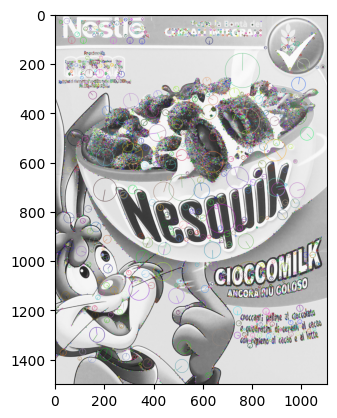

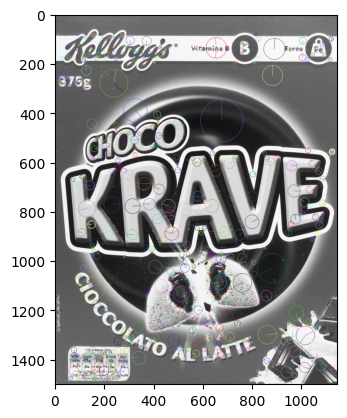

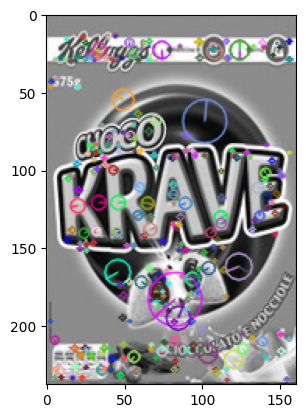

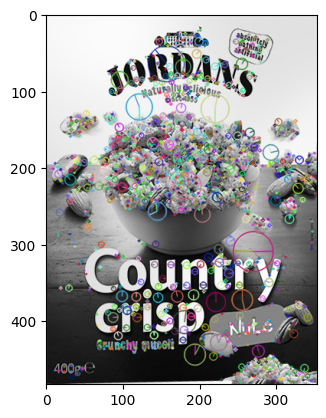

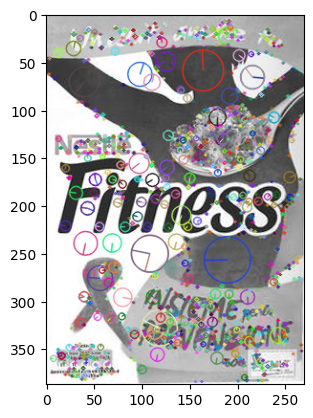

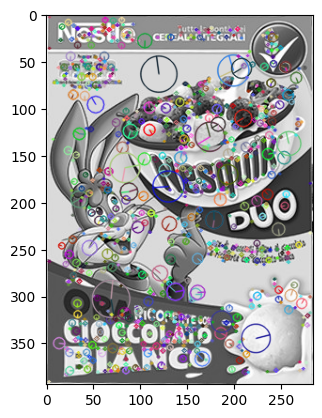

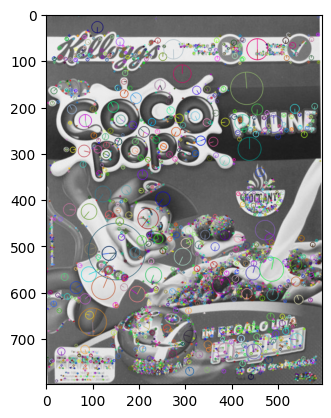

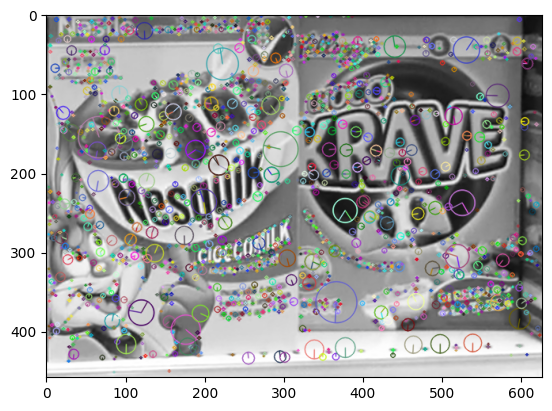

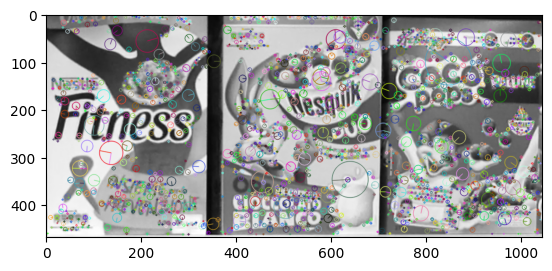

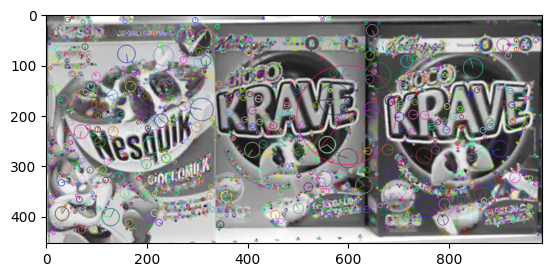

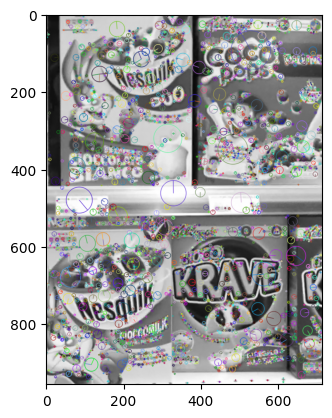

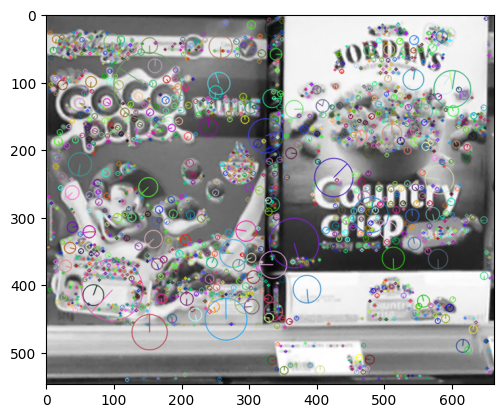

In [ ]:
image_dict = {}
models_dict = {}
scenes_dict = {}
description_dict = {}
description_models = []
description_scenes = []

def compute_keypoints(images, sift):
    image_dict = {}
    description_dict = {}
    for img in images:
        keypoints, descr = sift.detectAndCompute(images[img], None)
        description_dict[img] = descr
        image_dict[img] = {'keypoints': keypoints, 'description': descr}
        img_visualization = cv2.drawKeypoints(images[img],keypoints,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_visualization)
        plt.show()
    return image_dict, description_dict

models_dict, description_models = compute_keypoints(references_gray, sift)
scenes_dict, description_scenes = compute_keypoints(scene_gray, sift)

**Matching**

The function `matching_Lowe` uses the FLANN algorithm to find matches between the descriptors `descr_scene` and `descr_ref`. It applies Lowe's ratio test to keep only the matches considered valid, where the distance of the best match is significantly lower than the second-best match. It returns both all found matches and those that pass this test.

In [ ]:
def matching_Lowe(descr_scene,descr_ref):
  FLANN_INDEX_KDTREE = 1
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks = 50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  # Matching the descriptors
  matches = flann.knnMatch(descr_ref,descr_scene,k=2)
  # Keeping only good matches as per Lowe's ratio test.
  good = []
  for m,n in matches:
    if m.distance < 0.5*n.distance:
      good.append(m)
  return matches, good

**Mask**

In the `masking() `function, masks for each model in the scene are generated. It requires a minimum number of matches  to locate the analyzed model in the scene. If enough matches are found, matched keypoints' locations are extracted in both images, forming arrays of good matches (src pts and dst pts). Using OpenCV, a robust homography is estimated by mapping model keypoints to their corresponding ones in the scene via RANSAC. RANSAC takes the good match arrays as input.

**Color Filtering**

Since there may be some products which are similar
but **differ for the color of the box**, before considering the match a good match, a last filtering based
on the color of the region of interest in the model and in the scene is performed, **otherwise the
system may consider two boxes with different color as the same**

The **color filtration process** measures the distinction between the average color of the reference model and that of similar models present in the scene.
If this discrepancy falls below a predefined threshold, an additional evaluation is initiated within the function. This subsequent phase involves scrutinizing the bounding box dimensions and their respective corners.

The code checks if the center of the cropped region or the center of the recognized region are within the rectangle of the current region. If there is an overlap, ok_color becomes False, and the loop ends. Otherwise, the current region is added to the list of recognized regions (recognised).

In [ ]:
from cv2.typing import Point
MIN_MATCH_COUNT = 30
import collections
from operator import itemgetter

def masking(scene, rgb_scene, models_rgb, models_dict, kp_scene,good_matches):
  count_product = 0
  recognised = {}
  rgb_scene_bb = rgb_scene
  good_match_sorted = collections.OrderedDict(sorted(good_matches.items(), key=itemgetter(1, 0), reverse=True))

  for ref,l in good_match_sorted.items():
    kp_model = models_dict[ref]['keypoints']
    count_product = 0

    if (good_match_sorted[ref][0]) > MIN_MATCH_COUNT:
      src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good_match_sorted[ref][1]]).reshape(-1,1,2)
      dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good_match_sorted[ref][1]]).reshape(-1,1,2)

      # Calculating homography based on correspondences
      M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
      h, w, channels = models_rgb[ref].shape
      h_scene,w_scene = scene.shape

      pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
      dst = cv2.perspectiveTransform(pts,M)

      center = tuple((dst[0, 0, i] + dst[1, 0, i] + dst[2, 0, i] + dst[3, 0, i]) / 4 for i in (0, 1))
      x1 = int((dst[0,0,0] + dst[1,0,0]) / 2) if (int((dst[0,0,0] + dst[1,0,0]) / 2) > 0) else 0
      y1 = int((dst[0,0,1] + dst[3,0,1]) / 2) if (int((dst[0,0,1] + dst[3,0,1]) / 2) > 0) else 0
      x2 = int((dst[2,0,0] + dst[3,0,0]) / 2) if (int((dst[2,0,0] + dst[3,0,0]) / 2) < w_scene) else w_scene
      y2 = int((dst[1,0,1] + dst[2,0,1]) / 2) if (int((dst[1,0,1] + dst[2,0,1]) / 2) < h_scene) else h_scene

      #color-filtering

      query_color = models_rgb[ref].mean(axis=0).mean(axis=0)
      train_crop = rgb_scene[y1:y2,x1:x2]
      train_color = train_crop.mean(axis=0).mean(axis=0)

      color_diff = np.sqrt(np.sum([value ** 2 for value in abs(query_color - train_color)]))

      ok_color = True
      if color_diff < 50:
        for r, corners in recognised.items():
            r_center = ((corners[0, 0, 0] + corners[1, 0, 0] + corners[2, 0, 0] + corners[3, 0, 0]) / 4,
                        (corners[0, 0, 1] + corners[1, 0, 1] + corners[2, 0, 1] + corners[3, 0, 1]) / 4)

            x1_min, y1_min = min(corners[0, 0, 0], corners[1, 0, 0]), min(corners[0, 0, 1], corners[3, 0, 1])
            x2_max, y2_max = max(corners[2, 0, 0], corners[3, 0, 0]), max(corners[1, 0, 1], corners[2, 0, 1])

            if (x1_min < center[0] < x2_max and y1_min < center[1] < y2_max) or (x1 < r_center[0] < x2 and y1 < r_center[1] < y2):
              ok_color = False
              break

        if ok_color:
          recognised[ref] = dst
          count_product += 1
          rgb_scene_bb = cv2.polylines(rgb_scene,[np.int32(recognised[ref])],True,(0,255,0),3, cv2.LINE_AA)
          rgb_scene_bb = cv2.putText(rgb_scene_bb, str(ref) , [np.int32(center[0]), np.int32(center[1])], 16, 2, (0, 255, 0), 8, cv2.LINE_AA)
      mask_w = int(((dst[3, 0, 0] - dst[0, 0, 0]) + (dst[2, 0, 0] - dst[1, 0, 0])) /2)
      mask_h = int(((dst[1, 0, 1] - dst[0, 0, 1]) + (dst[2, 0, 1] - dst[3, 0, 1])) /2)
    print("Product " + str(ref) + " – " + str(count_product) + " instance/s found" )

    if count_product > 0:
      center_round = tuple([round(x) if isinstance(x, float) else x for x in center])
      # Drawing bounding box
      print("\tIstance {Position: " + str(center_round) + ", width:" + str(mask_w) + "px, height:" + str(mask_h) + "px }")
  plt.imshow(cv2.cvtColor(rgb_scene_bb,cv2.COLOR_BGR2RGB))
  plt.show()

  return recognised

Product 0 – 1 instance/s found
	Istance {Position: (163, 215), width:310px, height:432px }
Product 1 – 0 instance/s found
Product 11 – 1 instance/s found
	Istance {Position: (444, 169), width:299px, height:390px }
Product 26 – 0 instance/s found
Product 25 – 0 instance/s found
Product 24 – 0 instance/s found
Product 19 – 0 instance/s found


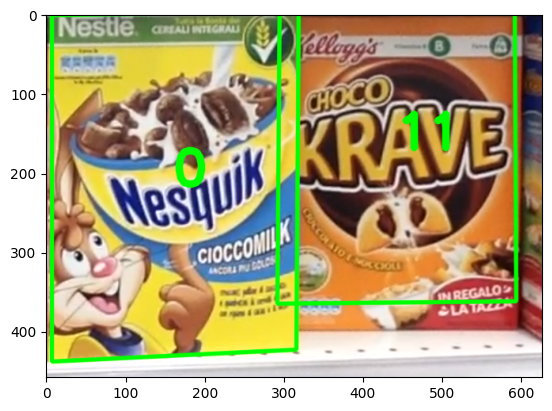

Product 26 – 1 instance/s found
	Istance {Position: (539, 218), width:333px, height:486px }
Product 24 – 1 instance/s found
	Istance {Position: (167, 219), width:334px, height:489px }
Product 25 – 1 instance/s found
	Istance {Position: (879, 233), width:312px, height:441px }
Product 0 – 0 instance/s found
Product 1 – 0 instance/s found
Product 19 – 0 instance/s found
Product 11 – 0 instance/s found


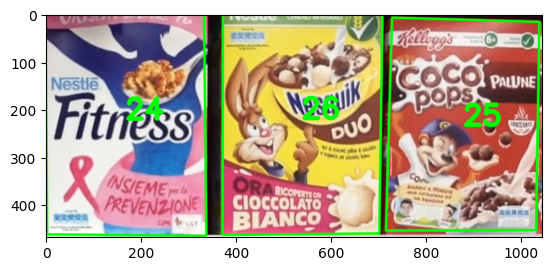

Product 0 – 1 instance/s found
	Istance {Position: (171, 237), width:324px, height:439px }
Product 1 – 0 instance/s found
Product 11 – 1 instance/s found
	Istance {Position: (475, 191), width:303px, height:393px }
Product 26 – 0 instance/s found
Product 25 – 0 instance/s found
Product 24 – 0 instance/s found
Product 19 – 0 instance/s found


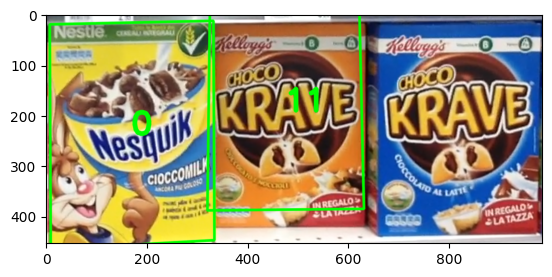

Product 0 – 1 instance/s found
	Istance {Position: (159, 739), width:324px, height:439px }
Product 26 – 1 instance/s found
	Istance {Position: (206, 195), width:340px, height:493px }
Product 25 – 1 instance/s found
	Istance {Position: (562, 277), width:355px, height:578px }
Product 1 – 0 instance/s found
Product 11 – 1 instance/s found
	Istance {Position: (463, 692), width:302px, height:395px }
Product 24 – 0 instance/s found
Product 19 – 0 instance/s found


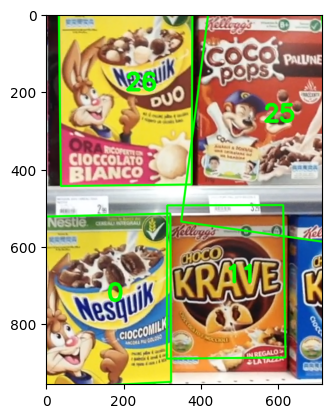

Product 25 – 1 instance/s found
	Istance {Position: (161, 229), width:321px, height:447px }
Product 19 – 1 instance/s found
	Istance {Position: (504, 190), width:295px, height:384px }
Product 1 – 0 instance/s found
Product 11 – 0 instance/s found
Product 26 – 0 instance/s found
Product 24 – 0 instance/s found
Product 0 – 0 instance/s found


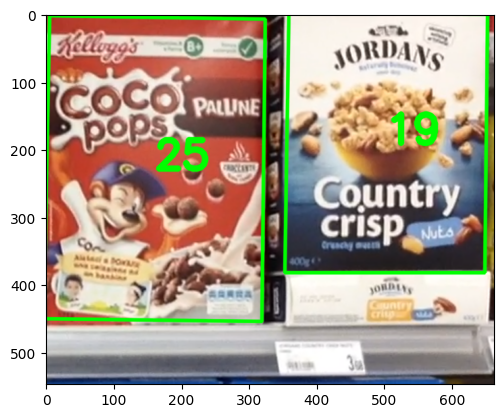

In [ ]:
good_matches = {}
for descr_scene in description_scenes:
  founded = {}
  kp_scene = scenes_dict[descr_scene]['keypoints']
  current_scene = scene_gray[descr_scene]
  s_descr = description_scenes[descr_scene]
  current_scene_rgb = scene_rgb[descr_scene]
  for descr_reference in description_models:
    kp_reference = models_dict[descr_reference]['keypoints']
    r_descr = description_models[descr_reference]
    matches, good = matching_Lowe(s_descr,r_descr)
    good_matches[descr_reference] = (len(good),good)
  founded = masking(current_scene, current_scene_rgb, references_rgb, models_dict, kp_scene, good_matches)
